In [174]:
import pathlib as pl
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
from icecream import ic

plt.style.use("ggplot")
ic.configureOutput(includeContext=True)

# Setup

In [175]:
reviews_path_1 = pl.Path(r"..\data\cities\reviews_Rotterdam_en.csv.gz")
# reviews_path_2 = pl.Path(r"..\data\cities\reviews_Amsterdam_en_2.csv.gz")
listings_path = pl.Path(r"..\data\cities\processed\listings_Rotterdam_processed.csv")
finished_path = pl.Path(r"..\data\cities\finished\listings_Rotterdam_finished.csv")
output_path = finished_path.parent / f"{finished_path.stem}_spacy.csv"
nlp = spacy.load(r"..\spacy_model\model-best")
ic("paths loaded!")

c:\ProgramData\anaconda3\envs\data_analytics\Lib\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'en_pipeline' (0.0.0) was trained with spaCy v3.7.5 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
ic| 4094948704.py:7 in <module>- 'paths loaded!'


'paths loaded!'

# Load data

In [176]:
def load_data(path: pl.Path | str, compression: None | str = None) -> pd.DataFrame:
    path = pl.Path(path)
    if compression is not None:
        return pd.read_csv(path, compression=compression)
    else:
        return pd.read_csv(path)

# review_data_1 = load_data(reviews_path_1, "gzip")
# review_data_2 = load_data(reviews_path_2, "gzip")
# review_data = pd.concat([review_data_1, review_data_2])
review_data = load_data(reviews_path_1)

listings_data = load_data(listings_path)
finished_data = load_data(finished_path)

ic("data loaded!")

ic| 1587161569.py:16 in <module>- 'data loaded!'


'data loaded!'

# Predict ratings

In [177]:
def predict_rating(df: pd.DataFrame, nlp: spacy.Language, review_column: str = "comments") -> pd.DataFrame:

    def predict(text: str, nlp: spacy.Language) -> int:
        try:
            doc = nlp(text)
        except ValueError as e:
            msg = f"try to predict: {text} -- wrong type: {type(text)} -- pedictions have to be of type 'str'"
            ic(msg)
            doc = False

        if doc:
            cat_values = list(doc.cats.values())
            cat_labels = list(doc.cats.keys())
            rating = int(cat_labels[cat_values.index(max(cat_values))])
        else:
            rating = np.nan
        return rating

    df["spacy_rating"] = df[review_column].apply(predict, args=(nlp,))
    return df

review_data = predict_rating(df=review_data, nlp=nlp, review_column="comments")
ic(review_data.head())

ic| 194595648.py:23 in <module>
    review_data.head():    listing_id      id        date  reviewer_id      reviewer_name  \
                        0       73155  286470  2011-05-29       516906            Daniela   
                        1       73155  337681  2011-06-27       570117            Lillian   
                        2       73155  358679  2011-07-07       129200  Andre And Rossana   
                        3       73155  364109  2011-07-10       660393             Denise   
                        4       73155  368273  2011-07-12       232321              Evert   
                        
                                                                    comments  spacy_rating  
                        0  Kim is a great host full of attention and care...             4  
                        1  The apartment is really nice, extremely clean ...             5  
                        2  Kim is a wonderful host with a beautiful apart...             5  
             

,listing_id,id,date,reviewer_id,reviewer_name,comments,spacy_rating
0,73155,286470,2011-05-29,516906,Daniela,Kim is a great host full of attention and care...,4
1,73155,337681,2011-06-27,570117,Lillian,"The apartment is really nice, extremely clean ...",5
2,73155,358679,2011-07-07,129200,Andre And Rossana,Kim is a wonderful host with a beautiful apart...,5
3,73155,364109,2011-07-10,660393,Denise,Kim's place is terrific. The apartment is very...,5
4,73155,368273,2011-07-12,232321,Evert,Most central location you could wish for. Apar...,4


# Combine listings and predicted_ratings

In [178]:
listings_combined = pd.merge(left=listings_data, right=review_data, left_on="listing_id", right_on="listing_id", how="inner")
listings_combined = listings_combined.groupby("listing_id", as_index=False).mean(numeric_only=True)
ic("combined!")


ic| 654043295.py:3 in <module>- 

'combined!'


'combined!'

# concat spacy predictions to finished data

In [179]:
# only concat if both datasets have equal rowcounts
rows_finished = finished_data.shape[0]
rows_predicted = listings_combined.shape[0]
if rows_finished == rows_predicted:
    finished_data["spacy_predict_avg"] = listings_combined["spacy_rating"].apply(lambda x: x)
    finished_data.to_csv(output_path, mode="w")
    ic(f"wrote file to {output_path}")
else:
    ic("cant concat dataframes; unequal row counts")
    ic(f"rows finished_dataset: {rows_finished} -- rows predicted_dataset: {rows_predicted}")

ic| 512271054.py:7 in <module>
    f"wrote file to {output_path}": ('wrote file to '
                                     '..\\data\\cities\\finished\\listings_Rotterdam_finished_spacy.csv')


# Evaluate spacy_predict_avg against true values (review_scores_rating)

residual Sum of Squares: $SS_{res} = \sum_i(y_i - y_{pred, i})^2$ 

total Sum of Squares: $SS_{tot} = \sum_i(y_i - \overline y)^2$

Root Mean Square Error: $RMSE = \sqrt{ \frac{1}{n} \sum_i(y_{pred, i} - \overline y)^2 }$ 

R-2 Value: $R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$

R-2-b Value: $R^2_b = \frac{ \sum_i(y_{pred, i} - \overline y)^2  }{ \sum_i (y_i - \overline y)^2 }$

In [180]:
def rmse(true_vals: np.ndarray, predicted_vals: np.ndarray) -> float:
    SS = np.sum(np.square(predicted_vals - true_vals))
    return np.sqrt(SS / len(true_vals))

def r_2(true_vals: np.ndarray, predicted_vals: np.ndarray) -> float:
    SSres = np.sum(np.square(predicted_vals - true_vals))
    SStot = np.sum(np.square(true_vals - np.mean(true_vals)))
    return 1 - (SSres / SStot)

def r_2_b(true_vals: np.ndarray, predicted_vals: np.ndarray) -> float:
    SQE = np.square(np.sum(predicted_vals - np.mean(true_vals)))
    SQT = np.square(np.sum(true_vals - np.mean(true_vals)))
    return SQE / SQT

def print_eval(true_vals: np.ndarray, predicted_vals: np.ndarray, title: str) -> None:
    print("="*50)
    print(title)
    print("="*50)
    print(f"RMSE: {rmse(true_vals, predicted_vals)}")
    print(f"R-2: {r_2(true_vals, predicted_vals)}")
    print(f"R-2-b: {r_2_b(true_vals, predicted_vals)}")
    print("="*50)

predict_eval = finished_data[["review_scores_rating", "xgb_predict_avg", "rf_predict_avg", "spacy_predict_avg"]]
predict_eval

true_vals = predict_eval["review_scores_rating"].to_numpy()
xgb__prediction = predict_eval["xgb_predict_avg"].to_numpy()
rf_prediction = predict_eval["rf_predict_avg"].to_numpy()
spacy_prediction = predict_eval["spacy_predict_avg"].to_numpy()

print_eval(true_vals, xgb__prediction, "evaluate xgb prediction")
print_eval(true_vals, rf_prediction, "evaluate rf prediction")
print_eval(true_vals, spacy_prediction, "evaluate spacy prediction")


evaluate xgb prediction
RMSE: 0.31690915886024046
R-2: -0.01806114278112858
R-2-b: 2.3852941326102637e+29
evaluate rf prediction
RMSE: 0.30572024595014163
R-2: 0.05255789582541348
R-2-b: 1.7262505892798142e+29
evaluate spacy prediction
RMSE: 0.6864839782870269
R-2: -3.777108350976996
R-2-b: 1.6927223581364454e+30


# Scatter of predictions

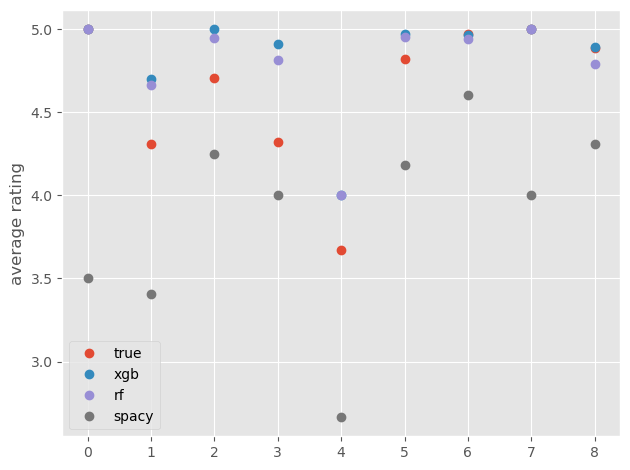

In [181]:
true_vals = predict_eval["review_scores_rating"].sample(frac=0.01, axis=0, random_state=1)
xgb_vals = predict_eval["xgb_predict_avg"].sample(frac=0.01, axis=0, random_state=1)
rf_vals = predict_eval["rf_predict_avg"].sample(frac=0.01, axis=0, random_state=1)
spacy_vals = predict_eval["spacy_predict_avg"].sample(frac=0.01, axis=0, random_state=1)
x_axis = range(true_vals.shape[0])
fig, ax = plt.subplots()
ax.plot(x_axis, true_vals, marker="o", ls="", label="true")
ax.plot(x_axis, xgb_vals, marker="o", ls="", label="xgb")
ax.plot(x_axis, rf_vals, marker="o", ls="", label="rf")
ax.plot(x_axis, spacy_vals, marker="o", ls="", label="spacy")
ax.set_ylabel("average rating")
ax.legend()
fig.tight_layout()
plt.show()

# Count of prediction averages

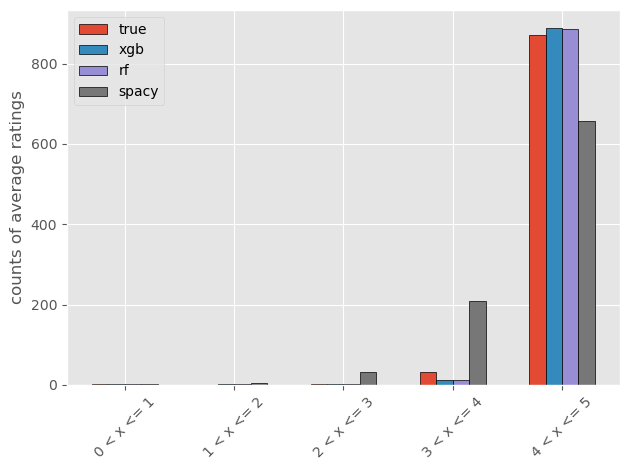

In [182]:
def counts(vals: np.ndarray) -> list[int]:
    count_1 = list()
    count_2 = list()
    count_3 = list()
    count_4 = list()
    count_5 = list()
    bucket = list()
    for x in vals:
        if (0 < x) and ( x <= 1):
            count_1.append(x)
        elif (1 < x) and (x <= 2):
            count_2.append(x)
        elif (2 < x) and (x <= 3):
            count_3.append(x)
        elif (3 < x) and (x <= 4):
            count_4.append(x)
        elif (4 < x) and (x <= 5):
            count_5.append(x)
        else:
            bucket.append(x)

    return [len(count_1), len(count_2), len(count_3), len(count_4), len(count_5)]

true_heights = counts(predict_eval["review_scores_rating"].to_numpy())
xgb_heights = counts(predict_eval["xgb_predict_avg"].to_numpy())
rf_heights = counts(predict_eval["rf_predict_avg"].to_numpy())
spacy_heights = counts(predict_eval["spacy_predict_avg"].to_numpy())
x_labels = ["0 < x <= 1", "1 < x <= 2", "2 < x <= 3", "3 < x <= 4", "4 < x <= 5"]
x_axis = np.arange(len(x_labels))
width = 0.15
fig, ax = plt.subplots()
ax.bar(x_axis, true_heights, width=width, edgecolor="black", label="true")
ax.bar(x_axis + width, xgb_heights, width=width, edgecolor="black", label="xgb")
ax.bar(x_axis + 2*width, rf_heights, width=width, edgecolor="black", label="rf")
ax.bar(x_axis + 3*width, spacy_heights, width=width, edgecolor="black", label="spacy")
ax.set_ylabel("counts of average ratings")
ax.set_xticks(x_axis + 1.5*width, x_labels, rotation=45)
ax.legend()
fig.tight_layout()
plt.show()
